# Sistema masa resorte amortiguador para MPC

Donde la ecuación diferencial es la siguiente

$m\cdot \ddot{y(t)} + c\cdot \dot{y(t)} + k\cdot y(t) = f(t)$

para pasar a variables de estado se utiliza la siguiente conversición 

$x_1(t) = y(t)$

$x_2(t) = \dot{y(t)}$

De esta manera 

$\dot{x_1(t)} = x_2(t)$

$ \dot{x_2(t)} = -\frac{c}{m}\cdot x_2(t) -\frac{k}{m}\cdot x_1(t) + \frac{1}{m}\cdot f(t) $

si se para a espacio de estados se obitne 

$\begin{bmatrix}\dot{x_1(t)}\\\dot{x_2(t)} \end{bmatrix}=\begin{bmatrix}0 & 1\\ \frac{-k}{m} & \frac{-c}{m} \end{bmatrix}  \begin{bmatrix}x_1(t)\\x_2(t) \end{bmatrix} +\begin{bmatrix}0\\\frac{1}{m}  \end{bmatrix}u(t)$

$\begin{bmatrix}\dot{x_1(t)}\\\dot{x_2(t)} \end{bmatrix}=\begin{bmatrix}1 &0 \end{bmatrix}\begin{bmatrix}x_1(t)\\x_2(t) \end{bmatrix}$



In [389]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import control

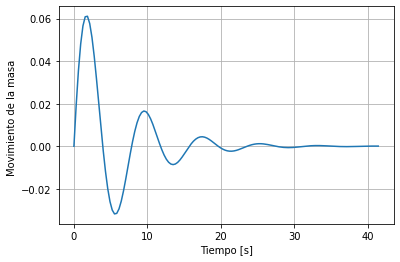

In [390]:
masa = 15
amortiguador = 5
K_resorte = 10

Hz = 20
Q = np.diag([2])
S = np.diag([1])
R = np.diag([0.01])


A = np.array([[0,1],[-K_resorte/masa,-amortiguador/masa]])
B = np.array([[0],[1/masa]])
C = np.array([0,1])
D = 0

sys = control.ss(A,B,C,D)


time,stepResponde = control.step_response(sys)
plt.plot(time,stepResponde)
plt.xlabel("Tiempo [s]")
plt.ylabel("Movimiento de la masa ")
plt.grid()
plt.show()


### Discretizando la ecuación diferencial

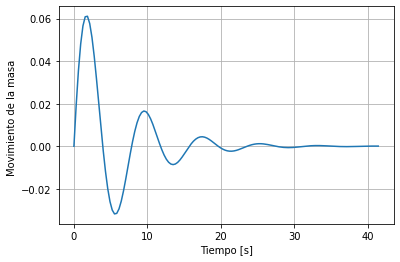

In [391]:
Ts = 0.001
sysd= control.c2d(sys,Ts)
Ad = sysd.A
Bd = sysd.B
Cd = sysd.C
Dd = sysd.D

time,stepResponde = control.step_response(sys)
plt.plot(time,stepResponde)
plt.xlabel("Tiempo [s]")
plt.ylabel("Movimiento de la masa ")
plt.grid()
plt.show()

### Se crean las matrices para hacer los calculos

In [392]:
A_aug = np.hstack([Ad,Bd])
temp1=np.zeros((np.size(Bd,1),np.size(Ad,1)))
temp2=np.identity(np.size(Bd,1))
temp=np.hstack([temp1,temp2])

A_aug = np.vstack([A_aug,temp])
B_aug = np.vstack([Bd,np.identity(np.size(Bd,1))])
C_aug = np.hstack([Cd,np.zeros([np.size(Cd,0),np.size(Bd,1)])])

CQC = C_aug.T@Q@C_aug
CSC = C_aug.T@S@C_aug
CQC_arr = [CQC]*(Hz)
CQC_arr[-1]=CSC

QC = Q@C_aug 
SC = S@C_aug
QC_arr = [QC]*(Hz)
QC_arr[-1] = SC

R_arr = [R]*Hz

Qdb = block_diag(*CQC_arr)
Tdb = block_diag(*QC_arr)
Rdb = block_diag(*R_arr)

Cdb = block_diag(*([B_aug]*Hz))

for row in range(1,Hz):
    for column in range(0,Hz):
        if np.array_equal(B_aug.T[0],Cdb[ row*(np.size(Bd,0)+1): (np.size(Bd,0)+1)*2*row , column]):
            break
        Cdb[ row*(np.size(Bd,0)+1): (np.size(Bd,0)+1)*row+(np.size(Bd,0)+1) , column] = ( np.linalg.matrix_power(A_aug,row-column)@B_aug ).T 



Adc = np.zeros([np.size(A_aug,0)*Hz,np.size(A_aug,1)])

for row in range(0,Hz):
    Adc[row*np.size(A_aug,0): np.size(A_aug,0)*(row+1) ,:] = np.linalg.matrix_power(A_aug,row+1)

Hdb = Cdb.T@Qdb@Cdb + Rdb

temp  = Adc.T@Qdb@Cdb
temp1 = -Tdb@Cdb

Fdbt = np.vstack([temp,temp1])   

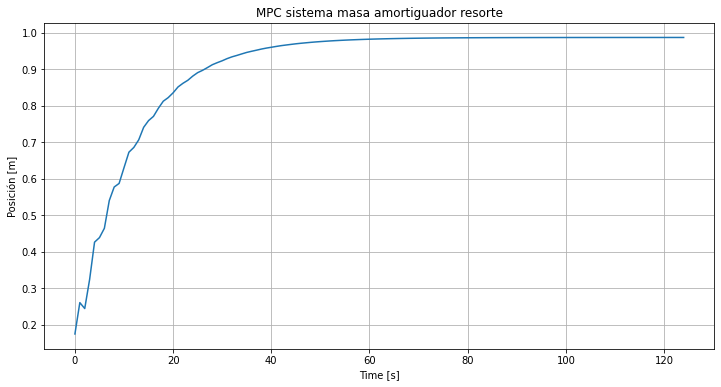

In [393]:
states = np.array([[0,0]])
ref = np.ones((Hz,1))*1
U = np.array([[0]])

sal = np.zeros(125)

for k in range(0,125):

    states_aug_t = np.hstack([states,U]).T

    aux = np.vstack([states_aug_t,ref]).T

    Ft = aux@Fdbt

    du = -np.linalg.inv(Hdb)@Ft.T

    U = U + du[0,0] 

    states = A@states.T + B*U 
    Y = C@states
    states = states.T

    sal[k] = Y

plt.figure(figsize=(12,6))
plt.plot(sal)
plt.grid()
plt.title("MPC sistema masa amortiguador resorte")
plt.ylabel("Posición [m]")
plt.xlabel("Time [s]")
plt.show()